<a href="https://colab.research.google.com/github/LuFernandez/PASA/blob/master/TP1.%20Laboratorio%20de%20estimaci%C3%B3n%20no-param%C3%A9trica/Informe/Ejercicio1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejercicio 1



## Preparativos
Debe guardarse el archivo readligo.py en el directorio correspondiente para poder leer los datos correctamente.

### Clonamos el repositorio de Github

In [1]:
#https://medium.com/@navan0/how-to-push-files-into-github-from-google-colab-379fd0077aa8
!git clone https://github.com/LuFernandez/PASA.git

Cloning into 'PASA'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 115 (delta 36), reused 89 (delta 25), pack-reused 0
Receiving objects: 100% (115/115), 8.65 MiB | 32.55 MiB/s, done.
Resolving deltas: 100% (36/36), done.


In [0]:
!git init
!git config — global user.email “togonzalez@itba.edu.ar”
!git config — global user.name “taomasgonzalez”

### Imports necesarios a lo largo del ejercicio

In [0]:
import h5py as h5
from scipy import signal as scsig
import numpy as np
import matplotlib.pyplot as plt
import readligo as rl
from scipy import fftpack as scfft

## Lectura de datos

In [0]:
def read_data(path, name):
  strain, time, chan_dict = rl.loaddata(path, name)
  dt = time[1] - time[0]
  times = dt*np.array([i for i in range(len(strain))])
  return (strain, times, chan_dict)

fs = 4096
folder_path = "PASA/TP1. Laboratorio de estimación no-paramétrica/LIGO/"
# leemos los datos de Livingston
strain_l1, times_l1, chan_dict_l1 = read_data(path=folder_path+'L-L1_LOSC_4_V2-1126259446-32.hdf5', name='L1')

# leemos los datos de Hanford
strain_h1, time_h1, chan_dict_h1 = read_data(path=folder_path+'H-H1_LOSC_4_V2-1126259446-32.hdf5', name='H1')


## Visualización de datos

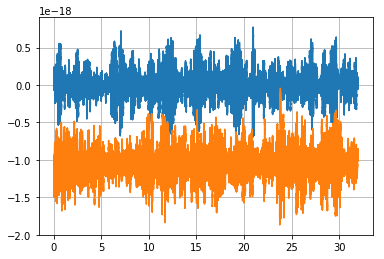

In [5]:
plt.plot(times_l1, strain_h1)
plt.plot(time_h1, strain_l1)
plt.grid()
plt.show()

## a) Estimación del espectro de potencia del ruido mediante el uso de periodogramas

### Implementación del periodograma

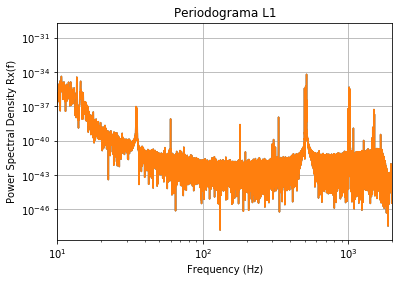

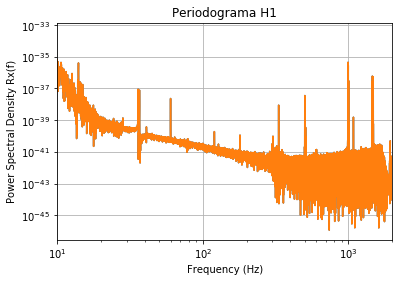

In [13]:
def periodogram(fs, data, figure_number, x_lim, title):
  # cantidad de muestras
  N = len(data)
  z = scfft.fft(x=data, n=N)
  R = z*np.conj(z)
  freqs = np.fft.fftfreq(N)
  xf = np.linspace(0, fs/2, N//2)    #frecuencias

  plt.loglog(xf, 2/N * np.abs(R[:N//2]))

  plt.loglog(xf, 2/N * np.abs(R[:N//2]))
  plt.xlim(x_lim)
  plt.grid()
  plt.title(title)
  plt.xlabel("Frequency (Hz)")
  plt.ylabel("Power Spectral Density Rx(f)")
  plt.show()
  return (freqs, R)

#f_l1, Pxx_l1 = periodogram(fs=fs, data=strain_l1, figure_number=1, x_lim=(10, 2000), y_lim=(10e-50, 1e-37), title="Periodograma L1")
f_l1, Pxx_l1 = periodogram(fs=fs, data=strain_l1, figure_number=1, x_lim=(10, 2000), title="Periodograma L1")
f_h1, Pxx_h1 = periodogram(fs=fs, data=strain_h1, figure_number=2, x_lim=(10, 2000), title="Periodograma H1")

### Implementación de Welch Barlett

In [0]:
def welch(fs, data, figure_number, x_lim, y_lim, title, window, nperseg)
  f, Pxx = scsig.welch(x=strain_l1, window='boxcar', nperseg, fs=fs)
  plt.figure(figure_number)
  plt.loglog(f, Pxx)
  plt.xlim(x_lim)
  plt.ylim(y_lim)
  plt.title(title)
  plt.grid()
  plt.show()
  return (f, Pxx)

f_w_l1, Pxx_w_l1 = welch(fs=fs, data=strain_l1, figure_number=1, x_lim=(20, 2000), y_lim=(1e-45, 1e-38),title="Welch-Bartlet L1", window='boxcar', nperseg=len(strain_l1)//5)
f_w_h1, Pxx_w_h1 = welch(fs=fs, data=strain_h1, figure_number=2, x_lim=(20, 2000), y_lim=(1e-45, 1e-38),title="Welch-Bartlet H1", window='boxcar', nperseglen(strain_h1)//5)

## b) Estimación 